In [1]:
import numpy as np
import h5py
import netCDF4 as nc
import oceanDAS as odas
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal
import warnings

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

plt.rc('font', size=12)

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def calc_means(das,dasTime,press,presTime,test_time):
    L = len(test_time)
    mean_das = np.empty([L])*np.nan
    mean_pre = np.empty([L])*np.nan
    for jj in range(L-1):
        mean_das[jj] = np.nanstd(np.absolute(das[(dasTime>test_time[jj]) & (dasTime<(test_time[jj+1]))]))
        mean_pre[jj] = np.nanstd(press[(presTime>test_time[jj]) & (presTime<(test_time[jj]+numvals))])
    
    return mean_das,mean_pre

def calc_means_hom(das,dasTime,sspec,sdate,test_time):
    L = len(test_time)
    mean_das = np.empty([L])*np.nan
    mean_pre = np.empty([L])*np.nan
    for jj in range(L-1):
        mean_das[jj] = np.nanmean(np.absolute(das[(dasTime>test_time[jj]) & (dasTime<(test_time[jj+1]))]))
        temp = sspec[(sdate>=test_time[jj]) & (sdate<test_time[jj+1]),:].flatten()
        
        mean_pre[jj] = np.nanstd(psd2time(temp))
    
    return mean_das,mean_pre

def psd2time(sspec):
    # Now undo the manual operation of P_fft_one_sided to get back to a time series, insert your PSD here
    N = 2*(len(sspec) - 1)

    # Because P includes both DC and Nyquist (N/2+1), P_fft must have 2*(N_P-1) elements
    sspec[0] = sspec[0] * 2
    sspec[-1] = sspec[-1] * 2
    P_fft_new = np.zeros((N,), dtype=complex)
    P_fft_new[0:int(N/2)+1] = sspec
    P_fft_new[int(N/2)+1:] = sspec[-2:0:-1]

    X_new = np.sqrt(P_fft_new)

    # Create random phases for all FFT terms other than DC and Nyquist
    phases = np.random.uniform(0, 2*np.pi, (int(N/2),))

    # Ensure X_new has complex conjugate symmetry
    X_new[1:int(N/2)+1] = X_new[1:int(N/2)+1] * np.exp(2j*phases)
    X_new[int(N/2):] = X_new[int(N/2):] * np.exp(-2j*phases[::-1])

    # This is the new time series with a given PSD
    x_new = np.real(np.fft.ifft(X_new))
    return x_new

In [3]:
# Duck
pname = 'DuckNC_Glover/'

# load pressure
with np.load(pname+'FRF-ocean_waveTs_awac-11m_202111.npz') as data:
    press = data['p']
    presTime = data['t']

# load strain
f = h5py.File(pname + 'ChNo436_Nov2021fromdown.hdf5', 'r') 
dasTime = f['Acquisition']['RawDataTime'][:]
das = f['Acquisition']['RawData'][:] # unit of E

# set training data periods
numvals = 60*20
t1 = datetime(2021, 11, 11, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2021, 11, 24, 0, 0, 0,tzinfo=timezone.utc).timestamp()
test_time = np.arange(t1,t2,numvals)

# Calculate avg |strain| and avg pressure over 20 mins
mean_das_duc,mean_pre_duc = calc_means(das,dasTime,press,presTime,test_time)                                          


In [4]:
# KNO
pname = 'KNO_Glover/'

# load pressure
with np.load(pname + 'rbr_pres_temp_all.npz') as data:
    press = data['p'][:,5] #5 is nearest ch124, h=11.5 m
    presTime = data['tvec']
press = press - np.mean(press)

# load strain data
with np.load(pname + 'filtstrain_F1_ch124.npz') as data:
    das = data['e']
    dasTime = data['t']

# set training data periods
t1 = datetime(2023, 1, 14, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2023, 2, 5, 0, 0, 0,tzinfo=timezone.utc).timestamp()
test_time = np.arange(t1,t2,numvals)
# Calculate avg |strain| and avg pressure over 20 mins
mean_das_kno,mean_pre_kno = calc_means(das,dasTime,press,presTime,test_time)                                          


In [5]:
pname = 'HomerAK_Williams/'

# load strain at all channels  then pull out channel 31
fname = 'GCI_TERRA_2p5Hz_data.h5'
onechn = False
das,dasTime,chnl,depth,metadata = odas.loadHomer(pname,fname,onechn)
das = das[~np.isnan(dasTime),31]
dasTime = dasTime[~np.isnan(dasTime)][:]
depth = depth[31]

# load ground truth spectra:
with h5py.File(pname+'NDBC-46108_spectra.h5','r') as fp:
    sdate = fp['DATE'][:]/1e9 # POSIX time stamp (s) (convert from ns to s)
    sfreq = fp['FREQ'][:] # Hz
    sspec = fp['SPEC'][:] # m^2/Hz

# Calculate depth attenuation function to translate buoy surface to pressure at bed 
L,_ = odas.dispersion(depth,1 / sfreq)
attenuation = np.exp((1/L)*np.abs(depth)*(-1))**2 # square for energy
attenuation[attenuation>100]=np.nan
sspec = sspec*attenuation

t1 = datetime(2023, 6, 10, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2023, 6, 25, 0, 0, 0,tzinfo=timezone.utc).timestamp()
numvals = 60*60
test_time = np.arange(t1,t2,numvals)

# convert spectra of pressure to pressure time series
# Calculate avg |strain| and avg pressure over 20 mins
mean_das_hom,mean_pre_hom = calc_means_hom(das,dasTime,sspec,sdate,test_time)                                      


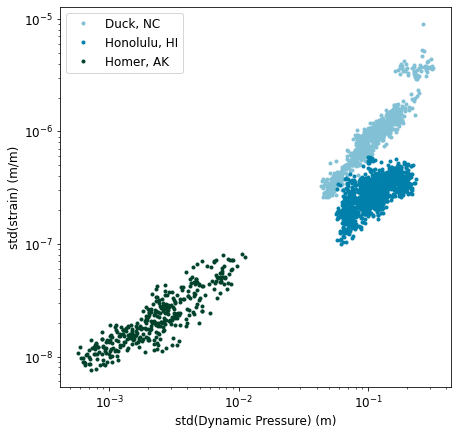

In [7]:
# load useful info like depth and noise floor freq for each site
h, f_noise, clrs = odas.all_line_info()

fig = plt.figure(figsize=(7,7))
plt.plot(mean_pre_duc,mean_das_duc,label='Duck, NC',c=clrs[0,:],marker='.',ls='None')
plt.plot(mean_pre_kno,mean_das_kno,label='Honolulu, HI',c=clrs[1,:],marker='.',ls='None')
plt.plot(mean_pre_hom,mean_das_hom,label='Homer, AK',c=clrs[4,:],marker='.',ls='None')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('std(Dynamic Pressure) (m)')
plt.ylabel('std(strain) (m/m)')

# fig.savefig('/Users/hglover/Downloads/F9_CalTime.png')